In [1]:
!pip install torchsummary

You are using pip version 9.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Xception import Xception

In [3]:
class ASPPConv1x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        ASPP用的5个处理之1，1个1x1卷积
        :param in_channels: 输入channels，是backbone产生的主要特征的输出channels，这里是2048
        :param out_channels: 输出channels，论文建议取值256
        """
        super(ASPPConv1x1, self).__init__()
        self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
                )

    def forward(self,x):
        x = self.step(x)
        return x

In [4]:
class ASPPConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        """
        ASPP用的5个处理之3，3个dilation conv，都是3x3的same卷积
        :param in_channels: dilation conv的输入channels，是backbone产生的主要特征的输出channels，这里是2048
        :param out_channels: dilation conv的输出channels，论文建议取值256
        :param dilation: 膨胀率，论文建议取值6,12,18
        """
        super(ASPPConv, self).__init__()
        # same卷积padding=dilation*(k-1)/2
        self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3,
                             padding=dilation, dilation=dilation, bias=False), 
                nn.BatchNorm2d(out_channels), 
                nn.ReLU()
                )

    def forward(self,x):
        x = self.step(x)
        return x

In [5]:
class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        ASPP用的5个处理之1，Image Pooling
        :param in_channels: 输入channels，是backbone产生的主要特征的输出channels，这里是2048
        :param out_channels: 输出channels，论文建议取值256
        """
        super(ASPPPooling, self).__init__()
        # 全局平均池化，输出特征图大小1，再1x1卷积调整channels
        self.step = nn.Sequential(nn.AdaptiveAvgPool2d(1),  
                   nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), 
                   nn.BatchNorm2d(out_channels), 
                   nn.ReLU()
                   )
        

    def forward(self, x):
        # 因为需要上采样，所以记录下输入的大小
        size = x.shape[-2:]  
        x = self.step(x)
        # 双线性差值上采样到原特征图大小 
        x = F.interpolate(x, size=size, mode='bilinear', align_corners=False)
        return  x


In [6]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        ASPP，对backbone产生的主干特征进行空间金字塔池化。
        金字塔有5层：1个1x1卷积，3个3x3 dilation conv，1个全局平均池化
        将5层cat后再调整channels输出。
        这里不进行upsample，因为不知道low-level的spatial大小。
        :param in_channels: 输入channels，是backbone产生的主要特征的输出channels，这里是2048
        :param out_channels: 输出channels，论文建议取值256
        """
        super(ASPP, self).__init__()
        modules = [ASPPConv1x1(in_channels, out_channels),  
                   ASPPConv(in_channels, out_channels, dilation=6),
                   ASPPConv(in_channels, out_channels, dilation=12), 
                   ASPPConv(in_channels, out_channels, dilation=18),
                   ASPPPooling(in_channels, out_channels)] 
        self.convs = nn.ModuleList(modules)
        # 一定要这样写，否则模型参数无法送入cuda
        # 因为是并行计算，所以self.convs不能用nn.Sequential
        # 金字塔池化后，输入channels为2048*5，输出channels还是256
        self.project = nn.Sequential(nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
                                     nn.BatchNorm2d(out_channels),
                                     nn.ReLU())  


    def forward(self, x):
        output = []
        for mod in self.convs:
            output.append(mod(x))
        # 拼接各个计算结果，dim=1即channel方向上拼接
        x = torch.cat(output, dim=1)
        x = self.project(x)
        return x

In [7]:
class DeepLabV3P(nn.Module):
    # ASPP最终输出channels=256
    aspp_out_channels = 256 
    # 论文中说low-level特征减少channels到48 
    reduce_to_channels = 48  

    def __init__(self, in_channels, n_class):
        super(DeepLabV3P, self).__init__()
         # 取得backbone
        self.backbone = Xception(in_channels) 
        # backbone的输出channels是2048，low_level的输出特征是128
        aspp_in_channels, low_level_in_channels = 2048,128
        # 金字塔池化
        self.aspp = ASPP(aspp_in_channels, self.aspp_out_channels)  
        # 将low_level的维度从128降低至47
        self.reduce_channels = nn.Sequential(nn.Conv2d(low_level_in_channels, self.reduce_to_channels, 1, bias=False),
                          nn.BatchNorm2d(self.reduce_to_channels),
                          nn.ReLU())

        # 高低特征融合后进行的操作，通道是高低特征通道的和，输出是256通道
        # 两个3x3卷积
        self.decode = nn.Sequential(nn.Conv2d(self.aspp_out_channels + self.reduce_to_channels,
                                    self.aspp_out_channels,
                                    3, padding=1, bias=False),
                          nn.BatchNorm2d(self.aspp_out_channels),
                          nn.ReLU(),
                          nn.Conv2d(self.aspp_out_channels,
                                    self.aspp_out_channels,
                                    3, padding=1, bias=False),
                          nn.BatchNorm2d(self.aspp_out_channels),
                          nn.ReLU())
        # 最终分类，用1x1卷积降维，输出通道数为分类数目
        self.classifier = nn.Conv2d(self.aspp_out_channels, n_class, 1)  

        # 初始化参数
        self._init_param()


    def _init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # 记录图像原始大小
        size1 = x.shape[-2:]  
        # 提取特征，主干特征high-level和低级特征low-level
        high_level, low_level = self.backbone(x)  
        # low-leveld减少channels到48
        low_level = self.reduce_channels(low_level)  
        # 读取low-level特征图大小，即aspp上采样目标
        size2 = low_level.shape[-2:]  

        # 空间金字塔池化
        high_level = self.aspp(high_level)  
        # 上采样至和low-level的特征图大小一致
        high_level = F.interpolate(high_level, size=size2, mode='bilinear',
                                   align_corners=False)  

        # cat融合一下
        x = torch.cat([high_level, low_level], dim=1) 
        # 后面跟一系列3x3卷积，选择2个3x3卷积 
        x = self.decode(x)
        # 最终分类 
        x = self.classifier(x)  
        # 上采样和原图像大小一致
        x = F.interpolate(x, size=size1, mode='bilinear', align_corners=False)
        return  x 

In [8]:
if __name__ == '__main__':
    device = torch.device('cuda:0')

    net = DeepLabV3P(3, n_class=3).to(device)
    print(net)

    in_data = torch.randn((4, 3, 256, 768))
    print('in data:', in_data.shape)
    in_data = in_data.to(device)

    out_data = net(in_data)
    out_data = out_data.cpu()
    print('out_data:', out_data.shape)

DeepLabV3P(
  (backbone): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): DownBlock(
      (sepconv1): SepConvBlock(
        (relu): ReLU()
        (sepconv): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (sepconv2): SepConvBlock(
        (relu): ReLU()
        (sepconv): SeparableConv2d(
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 

In [9]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

In [10]:
# 利用torch提供的Dataset类，定义我们自己的数据集
import pandas as pd
data = pd.read_csv('imgpath.csv')

class BagDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        img_name = data.img_path[idx]
        imgA = cv2.imread(img_name)
        imgA = cv2.resize(imgA, (640, 160))
        mask_name = data.mask_path[idx]
        imgB = cv2.imread(mask_name, 0)
        imgB = cv2.resize(imgB, (640, 160))
        imgB[imgB==76] = 1
        imgB[imgB>1] = 2
        imgB = imgB.astype('uint8')
        imgB = torch.FloatTensor(imgB)
        # print(imgB.shape)
        if self.transform:
            imgA = self.transform(imgA)
        return imgA, imgB


In [11]:
from datetime import datetime
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [12]:
# 在训练网络前定义函数用于计算Acc 和 mIou
# 计算混淆矩阵
def _fast_hist(label_true, label_pred, n_class):
    # mask把符合分类属性的位置取出来
    # label_true和label_pred中最大值均为n_class-1，
    # np.bincount统计各个数出现的次数，返回长度为序列最大值+1，
    # minlength是返回的最大长度，小于最大值+1时无效，此处minlength = n_class**2，和混淆矩阵尺寸相同
    # 返回一个n_class行n_class列的混淆矩阵，行是实际值，列是预测值
    # hist计算中最大值为(n_class-1)*n_class+n_class，即n_class**2，以n_class=3为例
    # 两者相加=0，实际为0，表示预测为0，
    # 两者相加=1，实际为0，表示预测为1，
    # 两者相加=2，实际为0，表示预测为2，
    # 两者相加=3，实际为1，表示预测为0，
    # 两者相加=4，实际为1，表示预测为1，
    # 两者相加=5，实际为1，表示预测为2，
    # 两者相加=6，实际为2，表示预测为0，
    # 两者相加=7，实际为2，表示预测为1，
    # 两者相加=8，实际为2，表示预测为2，
    # np.bincount用于统计各个数值的个数，reshape后就是混淆矩阵
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

In [13]:
# 根据混淆矩阵计算Acc和mIou
def label_accuracy_score(label_trues, label_preds, n_class):
    # 生成混淆矩阵形状的矩阵
    hist = np.zeros((n_class, n_class))
    # 计算各个批次结果的混淆矩阵和
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    # np.diag把对角线的值取出来（即分类正确的个数）求和，并除以总数，即正确率
    acc = np.diag(hist).sum() / hist.sum()
    # 忽略错误的情况下，计算每一类的正确率
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    # 忽略nan的求平均
    acc_cls = np.nanmean(acc_cls)
    # axis=1表示按行求和，表示实际某类的个数，
    # axis=0表示按列求和，表示预测某类的个数，
    # 相加之后正好多加了一次对角线的数，因此减去对角线
    # 相除之后表示某个类别预测正确的占正确的和错误的总和的比值
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
                hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    # 忽略nan的求平均
    mean_iu = np.nanmean(iu)
    return acc, acc_cls, mean_iu

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = torch.ones(class_num, 1)
        else:
            self.alpha = torch.tensor(alpha, requires_grad=True)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average
        
    def forward(self, inputs, targets):
        # inputs.shape = (N,C,H,W)
        N,C,H,W = inputs.shape
        # 将inputs的形状变成N,H,W,C
        inputs = inputs.permute([0,2,3,1])
        # 第三维进行softmax
        P = F.softmax(inputs,dim=3) 
        P = torch.clamp(P,0.0001,0.99)

        # one hot start
        # 生成和cross_entropy一样的shape形状,N,H,W,C
        class_mask = inputs.data.new(N,H,W,self.class_num).fill_(0)  
        # 需要更新，所以加入梯度计算
        class_mask = class_mask.requires_grad_() 
        # 取得目标的索引，前三维要与class_mask一致
        ids = targets.view(N,H,W,1) 
        # 利用scatter将ids的索引值将mask最后一个维度变成onehot，
        class_mask.data.scatter_(3, ids.data, 1)
        # one hot end

        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()

        # 采用统一的alpha值
        alpha = self.alpha
        
        probs = (P*class_mask).sum(3).view(N,H,W,1) 
        # 将softmax * one_hot格式，0的部分被消除，留下1的概率，即每个target的概率
        
        log_p = probs.log()
        # 取得对数
        
        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        # batch_loss就是取每一个batch的loss值
        
        
        # 最终将每一个batch的loss加总后平均
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [19]:
# 定义训练函数
def train(model,epo_num=50,n_class=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # 定义交叉熵损失函数
    criterion = FocalLoss(n_class).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # 记录训练过程相关指标
    all_train_iter_loss = []
    all_test_iter_loss = []
    test_Acc = []
    test_mIou = []
    # 记录开始时间
    prev_time = datetime.now()

    for epo in range(epo_num):

        # 训练
        train_loss = 0
        model.train()
        for index, (road, road_msk) in enumerate(train_dataloader):
            # road.shape = torch.Size([4, 3, 160, 640])
            # road_msk.shape = torch.Size([4,160,640])

            road = road.to(device)
            road_msk = road_msk.to(device)

            optimizer.zero_grad()
            output = model(road)


            loss = criterion(output, road_msk.long())
            loss.backward()  
            # 需要计算导数，则调用backward
            iter_loss = loss.item()  
            # .item()返回一个具体的值，一般用于loss和acc
            all_train_iter_loss.append(iter_loss)
            train_loss += iter_loss
            optimizer.step()

            output_np = output.cpu().detach().numpy().copy()
            output_np = np.argmax(output_np, axis=1)
            road_msk_np = road_msk.cpu().detach().numpy().copy()

            # 每15个bacth，输出一次训练过程的数据
            if np.mod(index, 15) == 0:
                print('epoch {}, {}/{},train loss is {}'.format(epo, index, len(train_dataloader), iter_loss))

        # 验证
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for index, (road, road_msk) in enumerate(test_dataloader):
                road = road.to(device)
                road_msk = road_msk.to(device)

                optimizer.zero_grad()
                output = model(road)
                loss = criterion(output, road_msk.long())
                iter_loss = loss.item()
                all_test_iter_loss.append(iter_loss)
                test_loss += iter_loss

                # 把值小的那个位置取出来，即取出分类
                output_np = output.cpu().detach().numpy().copy()
                output_np = np.argmax(output_np, axis=1)
                road_msk_np = road_msk.cpu().detach().numpy().copy()

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('<---------------------------------------------------->')
        print('epoch: %d' % epo)
        print('epoch train loss = %f, epoch test loss = %f, %s'\
              % (train_loss / len(train_dataloader), test_loss / len(test_dataloader), time_str))

        acc, acc_cls, mean_iu = label_accuracy_score(road_msk_np, output_np, n_class)
        test_Acc.append(acc)
        test_mIou.append(mean_iu)

        print('Acc = %f, mIou = %f' % (acc, mean_iu))
        # 每5个epoch存储一次模型
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        if np.mod(epo+1, 5) == 0:
            # 只存储模型参数
            torch.save(model.state_dict(), 'checkpoints/deeplabv3p_Focalloss_{}.pth'.format(epo+1))
            print('saveing checkpoints/model_{}.pth'.format(epo+1))

    # 绘制训练过程数据
    plt.figure()
    plt.subplot(221)
    plt.title('train_loss')
    plt.plot(all_train_iter_loss)
    plt.xlabel('batch')
    plt.subplot(222)
    plt.title('test_loss')
    plt.plot(all_test_iter_loss)
    plt.xlabel('batch')
    plt.subplot(223)
    plt.title('test_Acc')
    plt.plot(test_Acc)
    plt.xlabel('epoch')
    plt.subplot(224)
    plt.title('test_mIou')
    plt.plot(test_mIou)
    plt.xlabel('epoch')
    plt.show()

In [21]:
# torch.cuda.empty_cache()
### 利用torchvision提供的transform，定义原始图片的预处理步骤（转换为tensor和标准化处理）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.35,0.35,0.35], std=[0.30, 0.30, 0.30])])
# 实例化数据集
road = BagDataset(transform)

train_size = int(0.9 * len(road))
test_size = len(road) - train_size
train_dataset, test_dataset = random_split(road, [train_size, test_size])

# 利用DataLoader生成一个分batch获取数据的可迭代对象
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
model = DeepLabV3P(3,3)
train(model,epo_num=100,n_class=3)

epoch 0, 0/65,train loss is 0.6795916557312012
epoch 0, 15/65,train loss is 0.3760790526866913
epoch 0, 30/65,train loss is 0.130100280046463
epoch 0, 45/65,train loss is 0.13425977528095245
epoch 0, 60/65,train loss is 0.09208767861127853
<---------------------------------------------------->
epoch: 0
epoch train loss = 0.204785, epoch test loss = 0.026102, Time 00:00:19
Acc = 0.893555, mIou = 0.517680
epoch 1, 0/65,train loss is 0.07343202084302902
epoch 1, 15/65,train loss is 0.04520348832011223
epoch 1, 30/65,train loss is 0.04575157165527344
epoch 1, 45/65,train loss is 0.03326216712594032
epoch 1, 60/65,train loss is 0.04575461149215698
<---------------------------------------------------->
epoch: 1
epoch train loss = 0.043776, epoch test loss = 0.022723, Time 00:00:19
Acc = 0.958789, mIou = 0.594125
epoch 2, 0/65,train loss is 0.0276497732847929
epoch 2, 15/65,train loss is 0.027483036741614342
epoch 2, 30/65,train loss is 0.04241308942437172
epoch 2, 45/65,train loss is 0.04971

KeyboardInterrupt: 

epoch 0, 0/65,train loss is 0.004701993428170681
epoch 0, 15/65,train loss is 0.013414930552244186
epoch 0, 30/65,train loss is 0.014201571233570576
epoch 0, 45/65,train loss is 0.014164912514388561
epoch 0, 60/65,train loss is 0.02700878493487835
<---------------------------------------------------->
epoch: 0
epoch train loss = 0.018414, epoch test loss = 0.147254, Time 00:00:19
Acc = 0.915479, mIou = 0.457739
epoch 1, 0/65,train loss is 0.0281929150223732
epoch 1, 15/65,train loss is 0.023099178448319435
epoch 1, 30/65,train loss is 0.018758367747068405
epoch 1, 45/65,train loss is 0.017825592309236526
epoch 1, 60/65,train loss is 0.012614247389137745
<---------------------------------------------------->
epoch: 1
epoch train loss = 0.017244, epoch test loss = 0.361082, Time 00:00:19
Acc = 0.772334, mIou = 0.386167
epoch 2, 0/65,train loss is 0.013378077186644077
epoch 2, 15/65,train loss is 0.015014683827757835
epoch 2, 30/65,train loss is 0.017257751896977425
epoch 2, 45/65,train l

epoch 19, 60/65,train loss is 0.018777139484882355
<---------------------------------------------------->
epoch: 19
epoch train loss = 0.012826, epoch test loss = 0.013348, Time 00:00:19
Acc = 0.944951, mIou = 0.516178
saveing checkpoints/model_20.pth
epoch 20, 0/65,train loss is 0.013155956752598286
epoch 20, 15/65,train loss is 0.018253812566399574
epoch 20, 30/65,train loss is 0.00988569762557745
epoch 20, 45/65,train loss is 0.01192246749997139
epoch 20, 60/65,train loss is 0.008269594982266426
<---------------------------------------------------->
epoch: 20
epoch train loss = 0.012393, epoch test loss = 0.012076, Time 00:00:19
Acc = 0.987920, mIou = 0.664729
epoch 21, 0/65,train loss is 0.01462539378553629
epoch 21, 15/65,train loss is 0.012383755296468735
epoch 21, 30/65,train loss is 0.011145521886646748
epoch 21, 45/65,train loss is 0.01408508513122797
epoch 21, 60/65,train loss is 0.017252637073397636
<---------------------------------------------------->
epoch: 21
epoch train

epoch 39, 0/65,train loss is 0.0075852456502616405
epoch 39, 15/65,train loss is 0.010771634057164192
epoch 39, 30/65,train loss is 0.019552836194634438
epoch 39, 45/65,train loss is 0.013654866255819798
epoch 39, 60/65,train loss is 0.008165528997778893
<---------------------------------------------------->
epoch: 39
epoch train loss = 0.009414, epoch test loss = 0.019688, Time 00:00:19
Acc = 0.964688, mIou = 0.606492
saveing checkpoints/model_40.pth
epoch 40, 0/65,train loss is 0.008472182787954807
epoch 40, 15/65,train loss is 0.008193728514015675
epoch 40, 30/65,train loss is 0.01014756504446268
epoch 40, 45/65,train loss is 0.00867672823369503
epoch 40, 60/65,train loss is 0.0075833760201931
<---------------------------------------------------->
epoch: 40
epoch train loss = 0.008839, epoch test loss = 0.014480, Time 00:00:19
Acc = 0.926670, mIou = 0.551907
epoch 41, 0/65,train loss is 0.00823920127004385
epoch 41, 15/65,train loss is 0.007058143615722656
epoch 41, 30/65,train loss

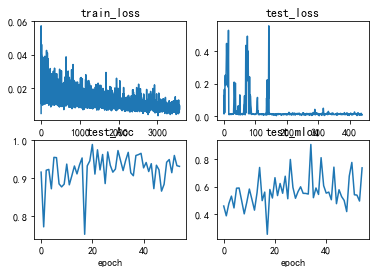

In [25]:
# 之前模型中断，加载参数后继续继续训练
model = DeepLabV3P(3,3)
model_path='./checkpoints/deeplabv3p_Focalloss_45.pth'
model.load_state_dict(torch.load(model_path))
train(model,epo_num=55)

In [26]:
import moxing as mox
mox.file.copy_parallel('/home/ma-user/work/checkpoints/deeplabv3p_Focalloss_55.pth',
                       'obs://class-1275-42687/Lab-2210/modelarts22926584/deeplabv3p_Focalloss_55.pth')

INFO:root:Using MoXing-v1.15.1-92d9ed92
INFO:root:Using OBS-Python-SDK-3.1.2
